In [27]:
import os
import itertools as it
import kalepy as kale
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from types import SimpleNamespace

# see https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
# for why we use multiprocess rather than multiprocessing,
from multiprocess import Pool

import src.utils as utils
import src.initial as initial
import src.target as target
from src.proposals import norm
import src.mcmc as mcmc

utils.configure_pd(pd)
utils.configure_plt(plt)

In [45]:
# Test 1: Meeting times as a function of dimension

mode_pairs_grid = [('full_max_indep','na'),
                   ('full_max_refl','na'),
                   ('max_indep','same_u'),
                   ('max_refl','same_u'),
                   ('max_indep','cond_same_u'),
                   ('max_refl','cond_same_u')]

# for paper, n_rep=10
# here we iterate until meeting occurs, so n_iter = max iters to run each chain for
pl = utils.add_iter([{'n_rep':100, 'n_iter':1000000,
                      'prop_mode':prop_mode, 'ar_mode':ar_mode,
                      'sigma2':3, 'offset':3, 'd':1,}
                     for (prop_mode, ar_mode) in mode_pairs_grid])

def f(par):
    n = SimpleNamespace(**par)
    pr = f' - offset={n.offset}, sigma2 = {n.sigma2}, prop_mode = {n.prop_mode} ({n.i+1}/{n.i_total})'

    init = initial.Initialize(mode='target_indep')
    prop = norm.NormalProposalOffset(d=1, prop_mode=n.prop_mode, sigma2=n.sigma2, offset=n.offset)
    targ = target.ExpoTarget()
    cmh = mcmc.CoupledMH(init, prop, targ, ar_mode=n.ar_mode, break_condition='meet',
                         record_items=('accrej', 'chain_positions'))
    cmh.run(n_iter=n.n_iter, n_rep=n.n_rep, verbose=True, pr_postfix=pr)

    df0 = cmh.return_df()
    df0['mode'] = f'{n.prop_mode} {n.ar_mode}'
    df0['par_idx'] = int(10000*n.par)
    return df0

df_list = []
with Pool(os.cpu_count()-2) as p:
    df_list += p.map(f, pl)

df = pd.concat(df_list)

10 - offset=3, sigma2 = 3, prop_mode = full_max_indep (1/6)
10 - offset=3, sigma2 = 3, prop_mode = max_refl (4/6)
10 - offset=3, sigma2 = 3, prop_mode = full_max_refl (2/6)
10 - offset=3, sigma2 = 3, prop_mode = max_indep (3/6)
10 - offset=3, sigma2 = 3, prop_mode = max_refl (6/6)
20 - offset=3, sigma2 = 3, prop_mode = full_max_indep (1/6)
20 - offset=3, sigma2 = 3, prop_mode = max_refl (4/6)
20 - offset=3, sigma2 = 3, prop_mode = full_max_refl (2/6)
30 - offset=3, sigma2 = 3, prop_mode = full_max_indep (1/6)
20 - offset=3, sigma2 = 3, prop_mode = max_indep (3/6)
30 - offset=3, sigma2 = 3, prop_mode = max_refl (4/6)
30 - offset=3, sigma2 = 3, prop_mode = max_indep (3/6)
40 - offset=3, sigma2 = 3, prop_mode = full_max_indep (1/6)
50 - offset=3, sigma2 = 3, prop_mode = full_max_indep (1/6)
30 - offset=3, sigma2 = 3, prop_mode = full_max_refl (2/6)
40 - offset=3, sigma2 = 3, prop_mode = max_refl (4/6)
60 - offset=3, sigma2 = 3, prop_mode = full_max_indep (1/6)
40 - offset=3, sigma2 = 3, p

In [46]:
df_t = df.groupby(['par_idx','rep_id','mode'])['t'].max().reset_index()
df_gp = df_t.groupby(['par_idx','mode'])[['t']]
df_avg = df_gp.mean()
df_avg['se'] = df_gp.sem()
df_avg.reset_index(inplace=True)

df_avg = df_avg.pivot(index='par_idx',columns='mode', values=['t','se'])

if df_avg.shape[0]==1:
    df_avg.loc[0] = df_avg.iloc[0]

df_avg = df_avg.reset_index()
df_avg.sort_values('par_idx', inplace=True)
df_avg['par'] = df_avg['par_idx']/10000

mode_summary = df_avg['t'].columns.tolist()

df_at = df_avg['t'].copy()
df_at['ratio'] = df_at['max_refl cond_same_u']/df_at['max_refl same_u']
df_at['par'] = df_avg['par']
df_at = df_at[['par','ratio']+mode_summary]

In [52]:
# Produce Table 2

df_out = df_avg.copy()
df_out = df_out.drop(columns='par').iloc[0]
df_out = df_out.reset_index()
df_out.columns = ['stat','mode','values']
df_out = df_out.pivot(columns='stat',index='mode',values='values')
df_out.drop(columns='par_idx',inplace=True)

modes = ['max_indep same_u', 'max_refl same_u',
         'full_max_indep na', 'full_max_refl na',
         'max_indep cond_same_u', 'max_refl cond_same_u']

df_out = df_out.loc[modes,:]

df_out = df_out.reset_index()

mode_labs = df_out['mode']

mode_labs = [lab.replace('max_refl cond_same_u', r'$\bar P_{C}$ with $\bar Q_{MR}$') for lab in mode_labs]
mode_labs = [lab.replace('max_refl same_u', r'$\bar P_{SQ}$ with $\bar Q_{MR}$') for lab in mode_labs]
mode_labs = [lab.replace('max_indep cond_same_u', r'$\bar P_{C}$ with $\bar Q_{MI}$') for lab in mode_labs]
mode_labs = [lab.replace('max_indep same_u', r'$\bar P_{SQ}$ with $\bar Q_{MI}$') for lab in mode_labs]
mode_labs = [lab.replace('full_max_indep na', r'$\bar P_{MI}$') for lab in mode_labs]
mode_labs = [lab.replace('full_max_refl na', r'$\bar P_{MR}$') for lab in mode_labs]

df_out['mode'] = mode_labs
df_out = df_out[['mode','t','se']]

print(df_out.to_latex(formatters={'t':'{:0.1f}'.format, 'se':'{:0.2f}'.format},
                      escape=False, index=False))

\begin{tabular}{lrr}
\toprule
                            mode &    t &   se \\
\midrule
$\bar P_{SQ}$ with $\bar Q_{MI}$ & 68.8 & 9.37 \\
$\bar P_{SQ}$ with $\bar Q_{MR}$ & 63.0 & 6.37 \\
                   $\bar P_{MI}$ & 47.0 & 5.85 \\
                   $\bar P_{MR}$ & 66.2 & 9.32 \\
 $\bar P_{C}$ with $\bar Q_{MI}$ & 65.6 & 8.70 \\
 $\bar P_{C}$ with $\bar Q_{MR}$ & 67.7 & 8.77 \\
\bottomrule
\end{tabular}



/Users/joleary/.conda/envs/mh-max-couplings/lib/python3.8/site-packages/pandas/core/generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


max_indep same_u $\bar P_{SQ}$ with $\bar Q_{MI}$ 100
max_refl same_u $\bar P_{SQ}$ with $\bar Q_{MR}$ 100
full_max_indep na $\bar P_{MI}$ 100
full_max_refl na $\bar P_{MR}$ 100
max_indep cond_same_u $\bar P_{C}$ with $\bar Q_{MI}$ 100
max_refl cond_same_u $\bar P_{C}$ with $\bar Q_{MR}$ 100


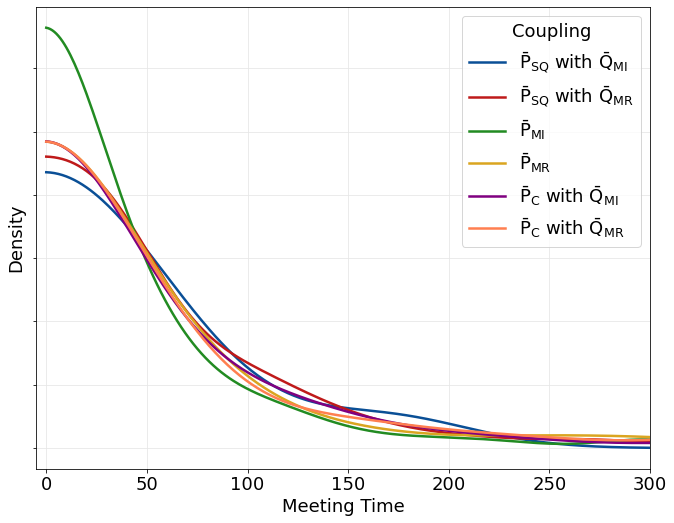

In [53]:
# Produce Figure 6: density plot of meeting time as a function of coupling

#mode_disp = modes
#mode_labs = mode_labs

# density plots
t_max = 300 #df_t.t.max()
t_grid = np.linspace(0, t_max, 1000, dtype=int)

for mode, lab in zip(mode_disp, mode_labs):
    mask = df_t['mode'] == mode
    print(mode,lab,sum(mask))
    dat = df_t.loc[mask, 't']
    kde = kale.KDE(dat)#,bandwidth=.2)
    pdf = kde.pdf(t_grid, reflect=[-1, np.inf])
    plt.plot(t_grid, pdf[1], label=lab)

plt.xlabel('Meeting Time')
plt.ylabel('Density')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.NullFormatter())
plt.xlim(xmin=-5, xmax=t_max)
plt.legend(ncol=1, title='Coupling')

plt.show()